In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import colors
from random import shuffle
from itertools import cycle, chain
from collections import defaultdict
import json
import yaml

%matplotlib inline

In [2]:
def plt_draw(graph, colors=None, figsize=(30,30)):
    if colors is None:
        colors = ["white" for n in graph.nodes]
    plt.figure(figsize=figsize)
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, with_labels=True, node_color=colors)

In [3]:
css_colors = list(colors.CSS4_COLORS.keys())
shuffle(css_colors)
colors = list(colors.BASE_COLORS.keys()) + css_colors
colors = cycle(colors)

In [4]:
def do_wave(n, color):
    print("Starting wave", n)
    waves[n] = list()
    for package in waves[n-1]:
        print(f"# {package}")
        what_requires = !dnf --repo=rawhide repoquery --qf '%{{NAME}}' --whatrequires {package} 2> /dev/null
        for dependant in what_requires:
            if dependant in exceptions:
                print("X", dependant, "has an exception")
                continue
            if dependant not in g.nodes:
                print("A", dependant, "→", package)
                waves[n].append(dependant)
                g.add_edge(dependant, package)
                node_colors.append(color)
    print(len(waves[n]), "new packages")
    return len(waves[n])

## Maintainers

In [5]:
with open("pagure_owner_alias.json") as fh:
    maintainers = json.load(fh)["rpms"]

## Exceptions

Get groups from portingdb

In [6]:
with open("/home/lbalhar/Dropbox/Projekty/portingdb/data/groups.yaml") as fh:
    groups = yaml.load(fh)

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Get all non-hidden source RPM packages (have an exception)

In [7]:
source_packages = []
for srpm, info in groups.items():
    if info.get("hidden", False):
        continue
    for package in info["packages"]:
        source_packages.append(package)

Get mapping from portingdb to get binary RPMs from source RPMs

In [8]:
with open("/home/lbalhar/Dropbox/Projekty/portingdb/_check_drops/results-sources.json") as fh:
    mapping = json.load(fh)

In [9]:
binary_packages = []
for package in source_packages:
    binary_packages.extend(mapping[package])

Final list of packages with approved exception

In [10]:
exceptions = binary_packages

In [11]:
exceptions.append("python2-capstone")  # Bogus dependencies https://bugzilla.redhat.com/show_bug.cgi?id=1760277#c1

In [12]:
exceptions.append("python3-dmidecode")  # Vztah "python3-dmidecode → python2-libxml2" je třeba odebrat, protože jde o stejný problém jako u capstone (python3-dmidecode requiruje libxml2mod.so()(64bit), to je providované oběma pythonX-libxml2).

## Wave #1 - packages directly depending on python27

In [13]:
waves = {}

In [14]:
python27 = !dnf --repo=rawhide repoquery --qf "%{NAME}" --whatrequires python27 2> /dev/null

In [15]:
waves[1] = set([p for p in python27 if p not in exceptions])

In [16]:
g = nx.DiGraph()
node_colors = []

In [17]:
g.add_nodes_from(waves[1])

In [18]:
for package in waves[1]:
    g.add_edge(package, "PYTHON2")
    # g.add_node(package)
    node_colors.append("red")
node_colors.append("red")

In [19]:
len(waves[1])

498

## Wave 2, 3, 4, …

In [20]:
for n in range(2, 20):
    color = next(colors)
    new_pkgs = do_wave(n, color)
    if new_pkgs == 0:
        break

Starting wave 2
# python2-qt5-webkit
# sugar-browse
# python2-pytest-runner
# python2-suds
# certmaster
# comedilib
A comedilib-devel → comedilib
# python2-elements
# drobo-utils
A drobo-utils-gui → drobo-utils
# python2-hamcrest
# gnome-python2-gconf
# trac-accountmanager-plugin
# python2-pyrtlsdr
# bios_extract
# python2-coverage
# python2-numpy-f2py
# tellico
# python2-scandir
# epydoc-gui
# sugar-fototoon
# python2-gtkextra
A audit-viewer → python2-gtkextra
# mercurial
A hgsvn → mercurial
A mercurial-chg → mercurial
A python3-hgapi → mercurial
A python3-wstool → mercurial
A rabbitvcs-core → mercurial
A rbm → mercurial
# python2-gobject-base
# python2-tpg
# python2-visvis
# gtkparasite
# sugar-starchart
# python2-hyperlink
# shedskin
# trac-authopenid-plugin
# sugar-flipsticks
# qpid-tools
# python2-mako
# python2-psycopg2
# sidc-gui
# python2-atomicwrites
# python2-progressbar
# trac-git-plugin
# python2-mutagen
# gonvert
# ddiskit
# system-config-httpd
# graphviz-python2
A sedimen

## Save

In [21]:
nx.write_adjlist(g, "full_graph.adjlist")

In [22]:
waves[1] = list(waves[1])

In [23]:
with open("wawes.json", "w") as fh:
    json.dump(waves, fh)
with open("node_colors.json", "w") as fh:
    json.dump(node_colors, fh)

## Load

In [24]:
with open("wawes.json") as fh:
    waves = json.load(fh)
with open("node_colors.json") as fh:
    node_colors = json.load(fh)

In [25]:
g = nx.read_adjlist("full_graph.adjlist", create_using=nx.DiGraph())

In [26]:
"PYTHON2" in g.nodes

True

## Graph manipulation

g_nc = g.copy()
g_nc

### Remove central node and isolated nodes

g_nc.remove_node("PYTHON2")

isolates = list(nx.isolates(g_nc))
g_nc.remove_nodes_from(isolates)

plt_draw(g_nc)

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


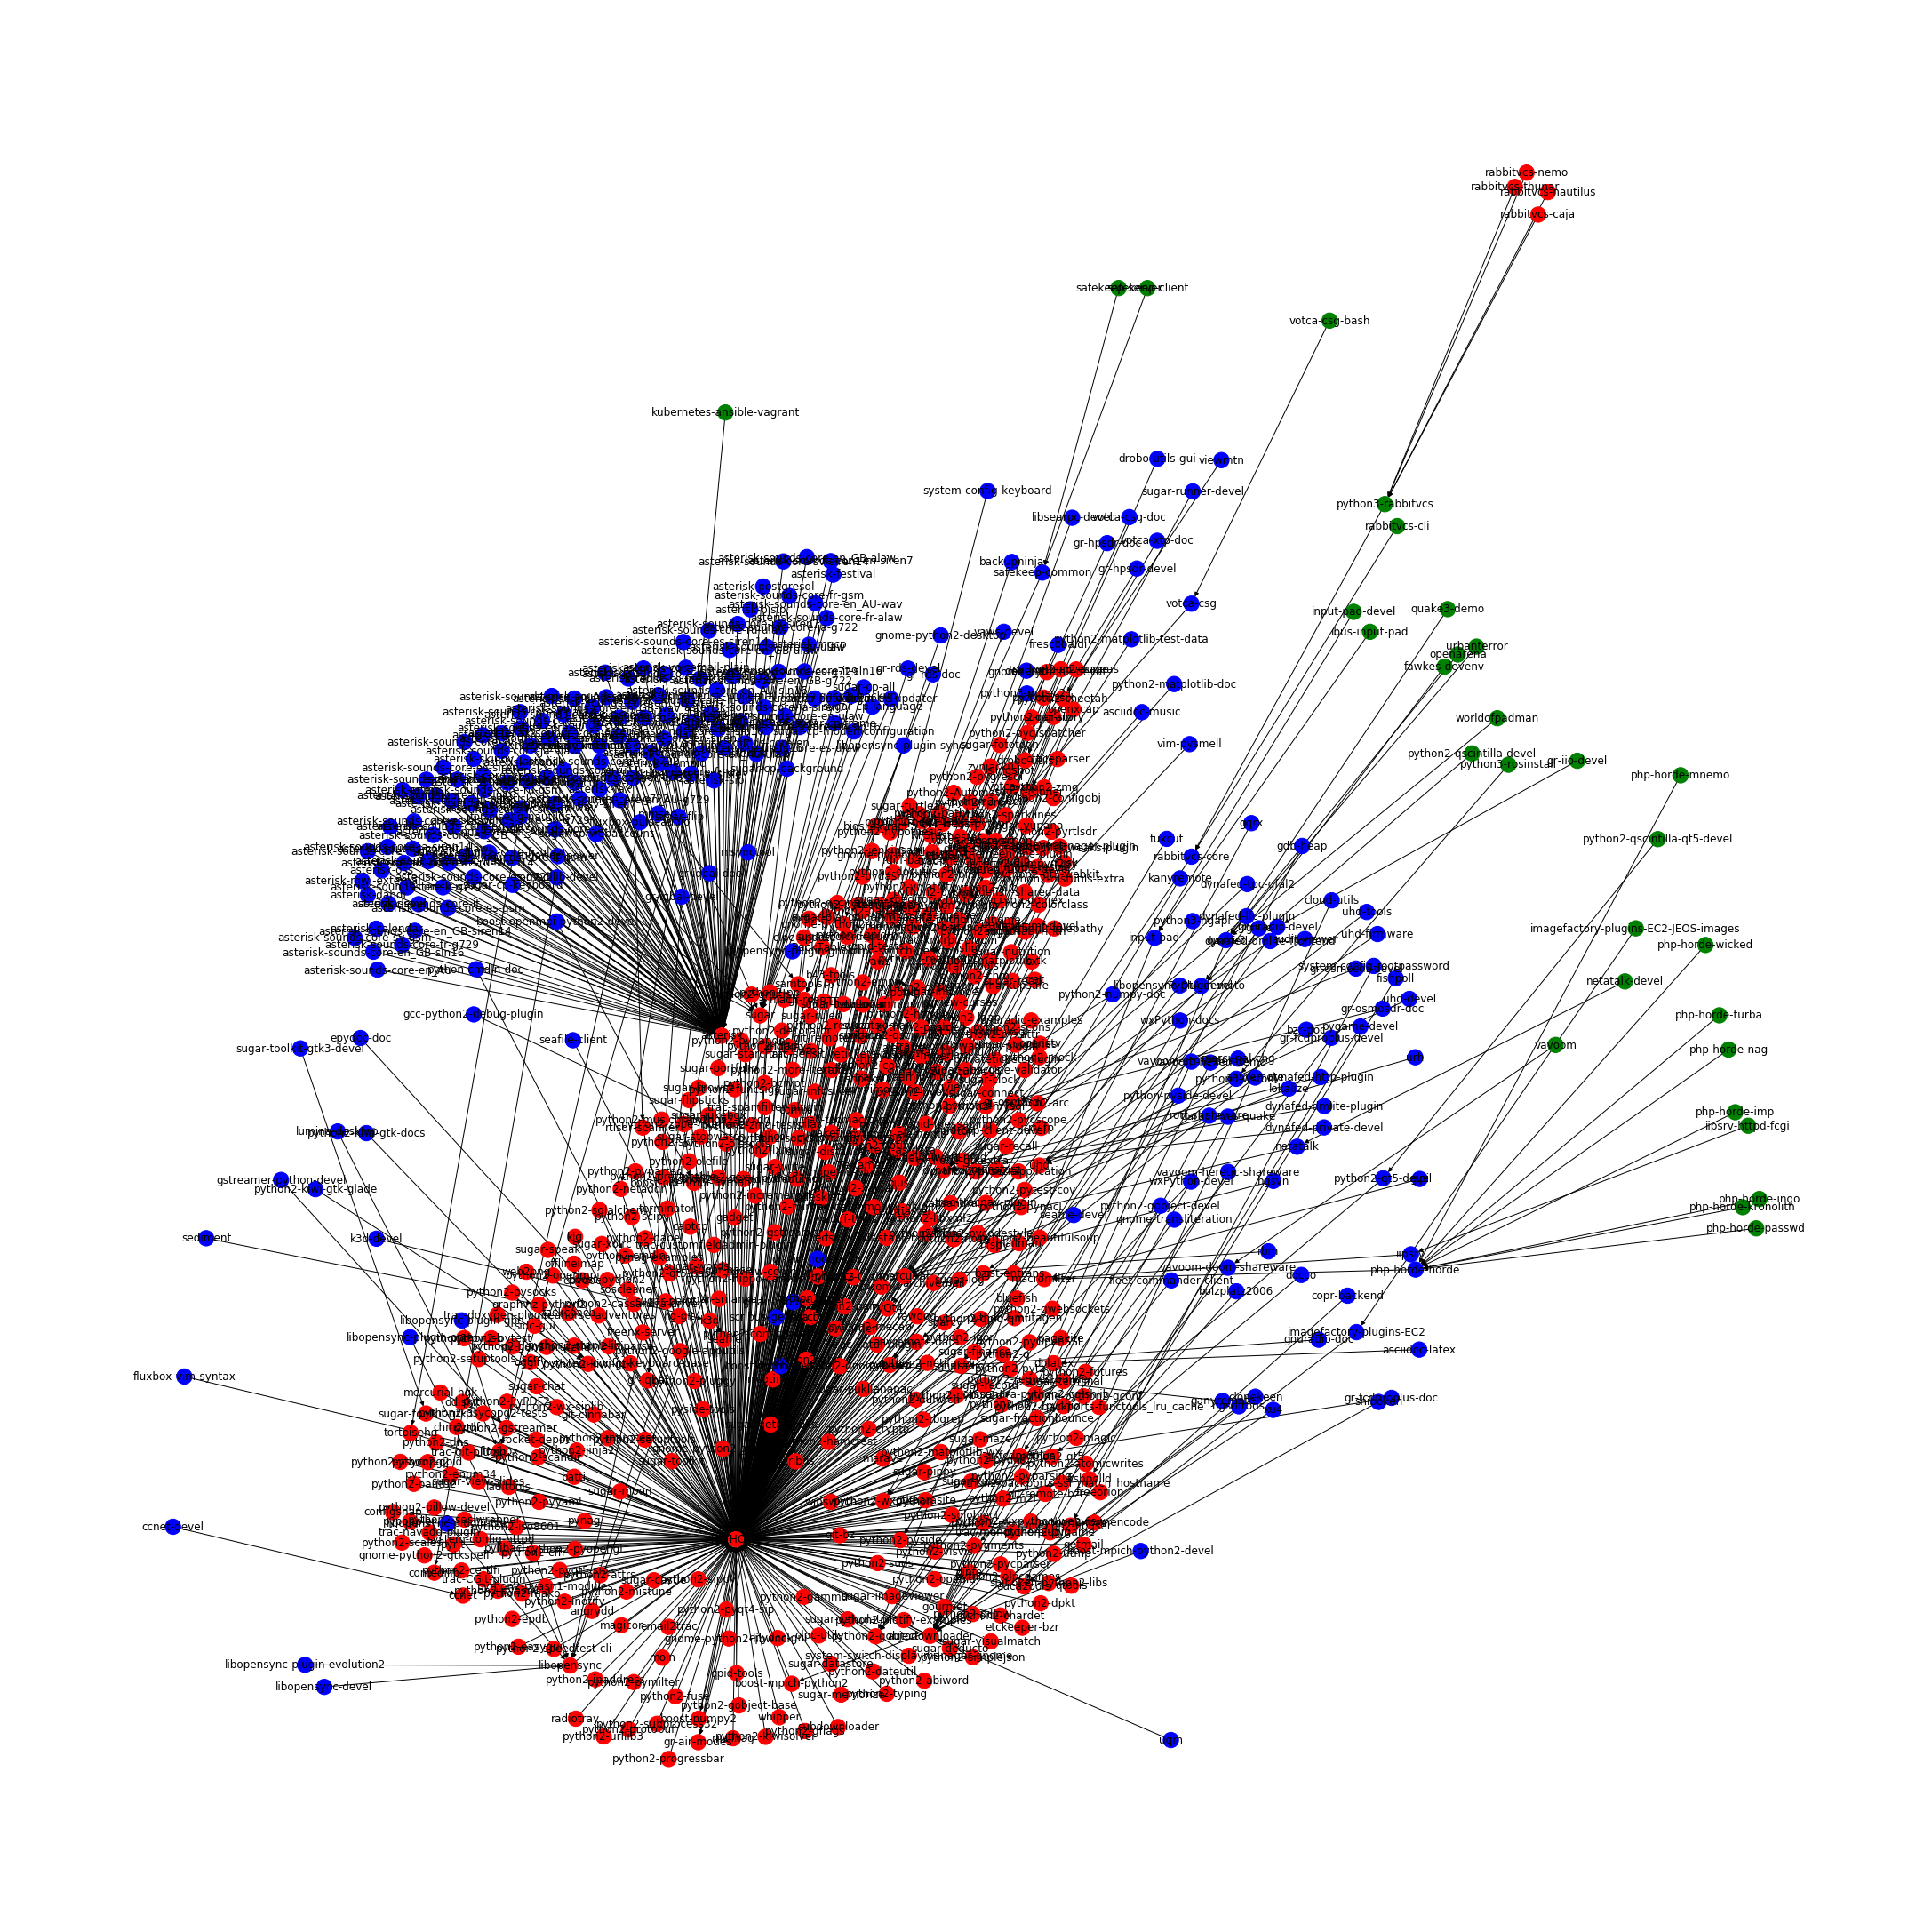

In [27]:
plt_draw(g, node_colors)

In [28]:
from networkx.algorithms.simple_paths import all_simple_paths
list(all_simple_paths(g, "rabbitvcs-nemo", "PYTHON2"))

[['rabbitvcs-nemo',
  'python3-rabbitvcs',
  'rabbitvcs-core',
  'mercurial',
  'PYTHON2']]

for sg in list(nx.weakly_connected_component_subgraphs(g_nc)):
    plt_draw(sg, figsize=(5,5))

## List of packages and theirs paths to Python 2 (including the packages in the first wave)

In [29]:
len(waves)

5

In [30]:
with open("packages.txt", "w") as packages_file:
    packages = list(chain(*[waves[str(n)] for n in waves.keys()]))
    print("Total packages", len(packages))
    for package in sorted(packages):
        path = list(all_simple_paths(g, package, 'PYTHON2'))[0]
        line = f"{package} ({' → '.join(path)})"
        print(line)
        print(line, file=packages_file)

!scp packages.txt fedorapeople.org:/home/fedora/lbalhar/public_html/ >/dev/null

Total packages 800
NFStest (NFStest → PYTHON2)
PyQt4 (PyQt4 → PYTHON2)
PyQt4-devel (PyQt4-devel → PyQt4 → PYTHON2)
PyQt4-webkit (PyQt4-webkit → PYTHON2)
PyRTF (PyRTF → PYTHON2)
RackTables (RackTables → PYTHON2)
TeXamator (TeXamator → PYTHON2)
alacarte (alacarte → PYTHON2)
angrydd (angrydd → PYTHON2)
anyremote (anyremote → anyremote-data → PYTHON2)
anyremote-data (anyremote-data → PYTHON2)
archivemail (archivemail → PYTHON2)
archmage (archmage → PYTHON2)
asciidoc-latex (asciidoc-latex → dblatex → PYTHON2)
asciidoc-music (asciidoc-music → lilypond → PYTHON2)
asterisk (asterisk → PYTHON2)
asterisk-ael (asterisk-ael → asterisk → PYTHON2)
asterisk-alembic (asterisk-alembic → asterisk → PYTHON2)
asterisk-alsa (asterisk-alsa → asterisk → PYTHON2)
asterisk-calendar (asterisk-calendar → asterisk → PYTHON2)
asterisk-corosync (asterisk-corosync → asterisk → PYTHON2)
asterisk-curl (asterisk-curl → asterisk → PYTHON2)
asterisk-dahdi (asterisk-dahdi → asterisk → PYTHON2)
asterisk-devel (asterisk-dev

## List of all SRPMs and theirs RPMs

In [31]:
inverse_map = {}
for srpm, pkgs in mapping.items():
    inverse_map.update({pkg: srpm for pkg in pkgs})

srpms = defaultdict(list)
for n in range(len(waves),1,-1):
    for package in waves[str(n)]:
        try:
            srpm = inverse_map[package]
        except KeyError:
            srpm = "N/A"
        srpms[srpm].append(package)

for srpm, packages in sorted(srpms.items(), key=lambda x: x[0]):
    print(f"{srpm} maintainers: {', '.join(maintainers[srpm])}, RPMs: {', '.join(packages)}")

## List of affected maintainers and their binary RPMs

In [32]:
affected_maintainers = defaultdict(list)
for package in packages:
    try:
        srpm = inverse_map[package]
    except KeyError:
        srpm = "N/A"
    for maintainer in maintainers[srpm]:
        affected_maintainers[maintainer].append(package)

with open("affected_maintainers.txt", "w") as affected_maintainer_file:
    for maintainer, pkgs in sorted(affected_maintainers.items(), key=lambda x: x[0]):
        line = f"{maintainer} - {', '.join(pkgs)}"
        print(line)
        print(line, file=affected_maintainer_file)

!scp affected_maintainers.txt fedorapeople.org:/home/fedora/lbalhar/public_html/ >/dev/null

aarem - python2-PyPDF2, python2-more-itertools, pdf-stapler, python2-staplelib
abbot - python2-protobuf
abompard - python2-coverage, python2-mako, python2-urllib3, python2-httplib2, python2-zope-event, python2-pysocks, python2-requests
acaringi - cassandra-python2-cqlshlib, cassandra
ajmitchell - NFStest
alexl - gnome-python2-gconf, python2-dbus, gnome-python2-devel, gnome-python2-gnomevfs, gnome-python2-canvas, alacarte, gnome-python2-rsvg, gnome-python2-gnome, python2-ldap, gnome-python2-gtkspell, gnome-python2-gnomekeyring, gnome-python2-libwnck, gnome-python2-desktop
alexlan - tellico, graphviz-python2, bibus, dblatex
alikins - certmaster, func
amitshah - pius
amluto - python2-musicbrainzngs
andreamanzi - dynafed, dynafed-dmlite-frontend, dynafed-dmlite-plugin, dynafed-http-plugin, dynafed-lfc-plugin, dynafed-private-devel, dynafed-tpc-gfal2
anishpatil - gnome-transliteration
ankursinha - python3-wstool
antiaircraft - gst-entrans
anyremote - ganyremote, kanyremote
aperezbios - suga

## Recipients

In [33]:
recipients = set(affected_maintainers.keys())
print(f"Total recipients: {len(recipients)}")
for recipient in recipients:
    print(f"{recipient}@fedoraproject.org")

Total recipients: 353
jskarvad@fedoraproject.org
pbrady@fedoraproject.org
huzaifas@fedoraproject.org
rebus@fedoraproject.org
jpopelka@fedoraproject.org
aperezbios@fedoraproject.org
caillon@fedoraproject.org
nushio@fedoraproject.org
oddshocks@fedoraproject.org
imcleod@fedoraproject.org
okeeble@fedoraproject.org
peter@fedoraproject.org
walters@fedoraproject.org
noodles@fedoraproject.org
jkaluza@fedoraproject.org
kwizart@fedoraproject.org
jmlich@fedoraproject.org
sharkcz@fedoraproject.org
mathstuf@fedoraproject.org
rstrode@fedoraproject.org
fale@fedoraproject.org
bkearney@fedoraproject.org
herrold@fedoraproject.org
sagitter@fedoraproject.org
fab@fedoraproject.org
toshio@fedoraproject.org
tremble@fedoraproject.org
limb@fedoraproject.org
tieugene@fedoraproject.org
than@fedoraproject.org
sgrubb@fedoraproject.org
filiperosset@fedoraproject.org
teuf@fedoraproject.org
ttomecek@fedoraproject.org
robled@fedoraproject.org
firewing@fedoraproject.org
manuq@fedoraproject.org
mrunge@fedoraproject.org
